In [1]:
import pairTrade
from pairTrade import pairTrade
import pandas as pd
import warnings
import pandas.util.testing as tm
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.tsa.stattools as ts 
import statsmodels.formula.api as sm
warnings.filterwarnings('ignore')

## plot
### 外部顯示
# %matplotlib qt 
### 內部
%matplotlib inline 
plt.figure(figsize = (20,20))

symbols = pd.read_csv(f"/Users/jochien/Documents/MaxRereach/backtrading/rawdata/1D/symbols.csv").symbol.tolist()
df = ((pd.concat([pd.read_csv(f"/Users/jochien/Documents/MaxRereach/backtrading/rawdata/1D/{symbol}.csv", index_col='date', parse_dates=True)
        ['close'].rename(symbol)for symbol in symbols],axis=1,sort=True)))
df = df.loc[:,~df.columns.duplicated()]

<Figure size 1440x1440 with 0 Axes>

# pair selection

In [2]:
### 波動度
def volatilityFiliter(df, tradeType, threshold = None, rolling = 20, plot = True):
    """
        Args:
            df (dataframe): raw data 
            tradeType (string): priceSpread, priceRatio, returnSpread, regression. 
            threshold (int):  
            rolling (int):  
    """
    tempList = []
    for A_symbol in df.columns:
        for B_symbol in df.columns:
            if A_symbol != B_symbol:
                if tradeType == 'priceSpread':
                    para = df[A_symbol] - df[B_symbol]
                elif tradeType == 'priceRatio':
                    para = df[A_symbol]/df[B_symbol]
                elif tradeType == 'returnSpread':
                    A_return = df[A_symbol].pct_change()
                    B_return = df[B_symbol].pct_change()
                    para = A_return - B_return
                elif tradeType == 'regression':
                    hedgeRatio=np.full(self.df.shape[0], 0.0)
                    for t in np.arange(self.rolling, len(hedgeRatio)):
                        regress_results=sm.ols(formula="{} ~ {}".format(A_Symbol, B_Symbol), data = df[(t-rolling):t]).fit() # Note this can deal with NaN in top row
                        hedgeRatio[t-1]=regress_results.params[1] ## beta1
                        para = df[A_symbol] - hedgeRatio * df[B_symbol]        
                zscore = (para-para.mean())/para.std()
                signal = ((zscore.shift(1)>0) & (zscore<=0)) | ((zscore.shift(1)<=0) & (zscore>0))
                num = len(signal[signal])
                tempList.append([A_symbol, B_symbol, num])
    result = pd.DataFrame(tempList, columns=['A_symbol', 'B_symbol', 'num']).sort_values('num').reset_index(drop=True)
    print('[average volatility] :', result['num'].mean())
    resultPivot = result.pivot("A_symbol", "B_symbol", "num")
    if plot:
        sns.heatmap(resultPivot, annot = True, xticklabels=1, yticklabels=1)
    if threshold is not None:
        resultFiliter = result[result['num'] >= threshold].reset_index(drop=True)
        return [resultFiliter['A_symbol'][i] + '_' + resultFiliter['B_symbol'][i] for i in range(resultFiliter.shape[0])]
        

## 相關性        
def correlation(df, threshold = None, plot = True):
    result = df.corr(method ='pearson')
    if plot:
        sns.heatmap(df.corr(), annot = True, xticklabels=1, yticklabels=1)

    if threshold is not None:
        resultFiliter = []
        for A_symbol in result.columns:
            for B_symbol in result.columns:
                if result.loc[A_symbol, B_symbol] >= threshold and A_symbol != B_symbol:
                    resultFiliter.append(A_symbol + '_' + B_symbol)
                    
    return resultFiliter

def minimum(df, threshold = None, plot = True):
    tempList = []
    for A_symbol in df.columns:
        for B_symbol in df.columns:
            if A_symbol != B_symbol:
                A_zscore = (df[A_symbol]-df[A_symbol].mean())/df[A_symbol].std()
                B_zscore = (df[B_symbol]-df[B_symbol].mean())/df[B_symbol].std()
                num = ((A_zscore-B_zscore)**2).sum()
                tempList.append([A_symbol, B_symbol, num])
    result = pd.DataFrame(tempList, columns=['A_symbol', 'B_symbol', 'num']).sort_values('num').reset_index(drop=True)
    print('[average minimum] :', result['num'].mean())
    resultPivot = result.pivot("A_symbol", "B_symbol", "num")
    if plot:
        sns.heatmap(resultPivot, annot = True, xticklabels=1, yticklabels=1)
    if threshold is not None:
        resultFiliter = result[result['num'] >= threshold].reset_index(drop=True)
        return [resultFiliter['A_symbol'][i] + '_' + resultFiliter['B_symbol'][i] for i in range(resultFiliter.shape[0])]

def cointegration(df, threshold = None,  plot = True):
    tempList = []
    for A_symbol in df.columns:
        for B_symbol in df.columns:
            if A_symbol != B_symbol:
                coin = ts.coint(df[A_symbol], df[B_symbol])
                tempList.append([A_symbol, B_symbol, coin[1]])
    result = pd.DataFrame(tempList, columns=['A_symbol', 'B_symbol', 'num']).sort_values('num').reset_index(drop=True)
    print('[average minimum] :', result['num'].mean())
    resultPivot = result.pivot("A_symbol", "B_symbol", "num")
    if plot:
        sns.heatmap(resultPivot, annot = True, xticklabels=1, yticklabels=1)
    if threshold is not None:
        resultFiliter = result[result['num'] < threshold].reset_index(drop=True)
        print(resultFiliter)
        return [resultFiliter['A_symbol'][i] + '_' + resultFiliter['B_symbol'][i] for i in range(resultFiliter.shape[0])]

In [3]:
vol = volatilityFiliter(df, 'priceRatio', threshold = 40, plot = False)
corr = correlation(df, 0.6, plot = False)
mini = minimum(df, 0.6, plot = False)
coin = cointegration(df, 0.05, plot = False)


interSection = list(set(vol) & set(corr) & set(mini) & set(coin))

print("[vol]", len(vol))
print("[corr]", len(corr))
print("[mini]", len(mini))
print("[coin]", len(coin))
print("[interSection]", len(interSection))

[average volatility] : 19.07112375533428
[average minimum] : 289.9307122918183
[average minimum] : 0.2601972522035346
      A_symbol   B_symbol        num
0      NEOUSDT  THETAUSDT 0.00000027
1     QTUMUSDT    VETUSDT 0.00000058
2      XMRUSDT  TFUELUSDT 0.00001445
3      ETCUSDT  TFUELUSDT 0.00001623
4      XMRUSDT  THETAUSDT 0.00002559
..         ...        ...        ...
317  TFUELUSDT    HOTUSDT 0.04635175
318    XMRUSDT    ONGUSDT 0.04662465
319  TFUELUSDT    ONGUSDT 0.04916696
320    ETCUSDT    FETUSDT 0.04933253
321  THETAUSDT    XLMUSDT 0.04973711

[322 rows x 3 columns]
[vol] 110
[corr] 1326
[mini] 1406
[coin] 322
[interSection] 36


In [10]:
totalPNL.index = df.index

ZILUSDT_XLMUSDT 回測結果，場上有單已平倉
-----------------------------ZILUSDT-XLMUSDT--------------------------
初始價格 100000
總損益:  -67942.74328351
總交易次數:  47
平均損益:  -1445.5902826279128
勝率:  0.5106382978723404
獲利因子:  0.43776592929144276
賺賠比:  0.41952568223763265
最大資金回落:  76145.60627140578
夏普比率:  -0.2700424092259501
FETUSDT_ADAUSDT 回測結果
-----------------------------FETUSDT-ADAUSDT--------------------------
初始價格 100000
總損益:  -22350.53334239
總交易次數:  49
平均損益:  -456.1333335182447
勝率:  0.4489795918367347
獲利因子:  0.8220668119804345
賺賠比:  1.0089001783396243
最大資金回落:  48615.71888987567
夏普比率:  -0.0787698322357806
MITHUSDT_QTUMUSDT 回測結果
-----------------------------MITHUSDT-QTUMUSDT--------------------------
初始價格 100000
總損益:  68834.91735835
總交易次數:  60
平均損益:  1147.2486226392114
勝率:  0.5166666666666667
獲利因子:  1.3696496834499905
賺賠比:  1.2812851877435394
最大資金回落:  50285.04950158046
夏普比率:  0.10186321658238336
QTUMUSDT_XRPUSDT 回測結果
-----------------------------QTUMUSDT-XRPUSDT--------------------------
初始價格 100000
總損益:

TRXUSDT_XRPUSDT 回測結果，場上有單已平倉
-----------------------------TRXUSDT-XRPUSDT--------------------------
初始價格 100000
總損益:  -47309.09708433
總交易次數:  46
平均損益:  -1028.458632268009
勝率:  0.45652173913043476
獲利因子:  0.5448219656281746
賺賠比:  0.6485975781287793
最大資金回落:  50951.92549267314
夏普比率:  -0.1898282462341547
TRXUSDT_QTUMUSDT 回測結果
-----------------------------TRXUSDT-QTUMUSDT--------------------------
初始價格 100000
總損益:  126543.87481168
總交易次數:  56
平均損益:  2259.7120502086373
勝率:  0.625
獲利因子:  1.847522902714837
賺賠比:  1.1085137416289021
最大資金回落:  57405.725684681354
夏普比率:  0.21065903090333446
WAVESUSDT_VETUSDT 回測結果
-----------------------------WAVESUSDT-VETUSDT--------------------------
初始價格 100000
總損益:  -42544.21663970
總交易次數:  42
平均損益:  -1012.9575390404439
勝率:  0.40476190476190477
獲利因子:  0.5745012052314389
賺賠比:  0.8448547135756455
最大資金回落:  54927.2620050188
夏普比率:  -0.19294277128953127
VETUSDT_FETUSDT 回測結果，場上有單已平倉
-----------------------------VETUSDT-FETUSDT--------------------------
初始價格 100000
總損益:  -3

Text(0, 0.5, 'equity curve')

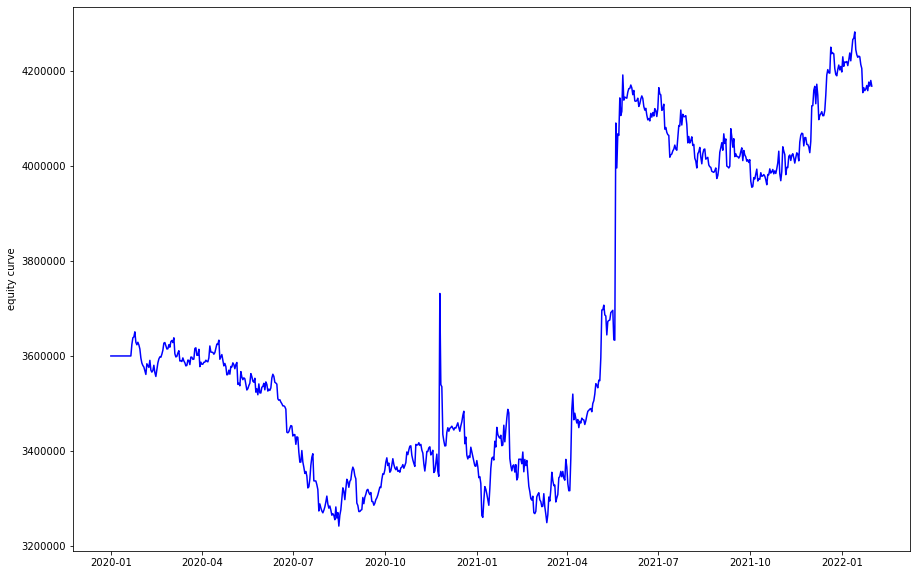

In [17]:
totalPNL = pd.DataFrame()
totalPNL.index = df.index
temp = 0
for i in interSection:
    A_symbol, B_symbol = i.split('_', 1 )[0], i.split('_', 1 )[1]
    df1 = df[[A_symbol, B_symbol]]
    ratio = pairTrade(df1)
    ratio.indicator(tradeType = 'priceRatio')
    ratio.strategy(strategyType = 'convergence', actionType = 'amount', entry = 1, exit = 0.2, stopLossType = 'trailingStop', trailingProfitTaking = 0.1, trailingStoploss = 0.05)
    totalPNL[i] = ratio.df['total']
    temp += 100000
#     ratio.pplot()
totalPNL['total'] = totalPNL.sum(axis = 1)

plt.figure(figsize = (15,10))
date = totalPNL.index
total = totalPNL['total']
plt.plot(date, total, color = 'b')
plt.ticklabel_format(axis="y", style="plain")
plt.ylabel("equity curve")

In [ ]:
norm_prices = df.divide(df.iloc[0])

plt.figure(figsize = (15, 10))
plt.plot(norm_prices)
plt.xlabel('days')
plt.title('Performance of cryptocurrencies')
plt.legend(symbols)
plt.show()

result_list = []
for a1 in df.columns:
    for a2 in df.columns:
        if a1 != a2:
            test_result = ts.coint(df[a1], df[a2])
            if test_result[1] < 0.05:
                print(a1 + ' and ' + a2 + ': p-value = ' + str(test_result[1]))
                result_list.append((a1, a2, test_result[1]))

In [ ]:
len(result_list)

* tradeType(priceRatio, priceSpread, returnSpread, priceRegression)
* strategyType: convergence 收斂策略, divergence 發散策略
* actionType: amount等金額購買, unit依比例購買
* entry 進場條件
* exit 出場條件
* signalStopLoss Defaults is None
* stopLoss 訊號停損
* singalStopLoss{固定停利停損 : fixedStopLoss, 移動停利停損 : trailingStop, 時間停利停損 : timeStop} 
* stopLossPara 停損參數 : fixedStopLoss 固定停利停損點位, trailingStop 移動停利停損點位, timeStop 時間停利停損時間間隔

# Ratio

### singal stoploss

In [ ]:
# for i in result_list[:1]:
# df1 = df[[i[0], i[1]]]
df1 = df[['BTCUSDT', 'ETHUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'priceRatio')
A.strategy(strategyType = 'convergence', actionType = 'amount', entry = 1, exit = 0, signalStopLoss = None)
A.pplot()

### stopLoss (fixedProfitTaking)